Import simulator and utilities

In [20]:
from Tfdtd.base import FDTD2D
from Tfdtd.utilities import print_setup_info
from Tfdtd.detectors import PointDetector
from Tfdtd.sources import PointSource, LineSource

from Tfdtd.viz import viz2D

### Setting the simulation parameters from a dictionary

In [34]:
params = {
    'backend': 'pytorch',
    'precision': 'float64',
    'nx': 200,
    'ny': 200,
    'time_steps': 150,
    'dx': 0.01,
    'dy': 0.01,
    'polarization': 'TM',
    'use_pml': True,
    'pml_thickness': 20,
    'use_tfsf': False,
    'tfsf_thickness': 10,
}

In [11]:
params = {
    'backend': 'pytorch',
    'precision': 'float64',
    'nx': 200,
    'ny': 200,
    'time_steps': 250,
    'dx': 0.01,
    'dy': 0.01,
    'polarization': 'TE',
    'use_pml': True,
    'pml_thickness': 20,
    'use_tfsf': False,
    'tfsf_thickness': 10,
}

### Testing initializations

In [60]:
sim = FDTD2D(params = params) # to read configuration from python dictionary
#sim = FDTD2D(config_file = 'config.yaml') # to read configuration from file

Reading configuration from dictionary...


### Try to change the background at time_step/2

In [61]:
for t in range(75,151):
    sim.eps_r[50:,:,t] = 12
sim.calculate_e_field_coefficients()

### Set detectors

In [62]:
detector_params = {
    'name': 'detector1',
    'position': (50, 50),
}
point_detector = PointDetector(detector_params)
sim.add_detector(point_detector)

### Set sources

In [51]:
source_params ={
    'source_type': 'point_source',
    'function': 'sinusoidal',
    'frequency': 1500e6,
    'source_x': 30,
    'source_y': 30
}
point_source = PointSource(source_params)
sim.add_source(point_source)

In [63]:
source_params ={
    'function': 'sinusoidal',
    'frequency': 1500e6,
    'source_type': 'line_source',
    'x': 20,
    'y1': 40,
    'y2': 60
}
line_source = LineSource(source_params)
sim.add_source(line_source)

### Set geometry

The geometry for this test is absent. Propagation in air.

### Print simulation info

In [64]:
print_setup_info(sim)

Simulation setup information:
nx: 200
ny: 200
time_steps: 150
dx: 0.01
dy: 0.01
dt: 2.358654336749684e-11
use_pml: True
pml_thickness: 20
c: 299792458
epsilon_0: 8.85418782e-12
mu_0: 1.25663706e-06
Source 0: source_type: line_source, function: sinusoidal, x: 20, y1: 40, y2: 60, frequency: 1500000000.0, omega: 9424777960.769379
Detector 0: Detector: detector1, Position: (50, 50)


### Show material distribution

### Test simulation

In [65]:
import numpy as np
import os

def save_field_component(field_component, field_name, time_step, output_dir="output"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    file_name = f"{field_name}_{time_step}.npy"
    file_path = os.path.join(output_dir, file_name)
    np.save(file_path, field_component)

In [66]:
for i in range(1, sim.time_steps):
        sim.simulation_step(i)
        sim.record_detectors(sim.e_field[:,:,2])
        save_field_component(sim.e_field, 'e_field', i)
        sim.time += sim.dt

In [67]:
import matplotlib.pyplot as plt
import numpy as np

def viz2D(sim,field):


    # plot the Ez field with cmap jet
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(np.transpose(field), cmap='Blues', extent=[0, sim.nx*sim.dx*1e6, sim.ny*sim.dy*1e6, 0])
    ax.set_xlabel('x (um)')
    ax.set_ylabel('y (um)')
    ax.set_title('Field')

    fig.colorbar(im)
    plt.show()

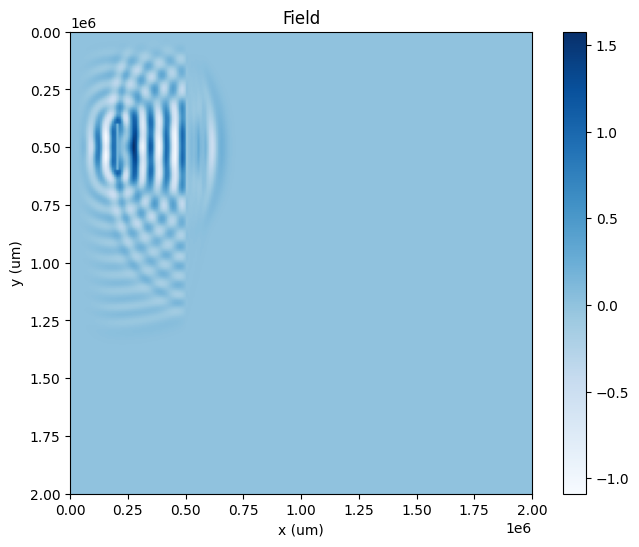

In [68]:
viz2D(sim,sim.e_field[:,:,2])

In [69]:
import matplotlib.pyplot as plt

def binary_to_image(binary_file, output_dir="output"):
    field_component = np.load(binary_file)
    normalized_field_component = (field_component - field_component.min()) / (field_component.max() - field_component.min()) * 2 - 1
    plt.imshow(normalized_field_component, cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(os.path.splitext(os.path.basename(binary_file))[0])
    image_file = os.path.splitext(os.path.basename(binary_file))[0] + ".png"
    plt.savefig(os.path.join(output_dir, image_file))
    plt.close()

for file_name in os.listdir("output"):
    if file_name.endswith(".npy"):
        binary_to_image(os.path.join("output", file_name))

C:\Users\mazzo\AppData\Local\Temp\ipykernel_10256\532506282.py:5: RuntimeWarning: invalid value encountered in true_divide
  normalized_field_component = (field_component - field_component.min()) / (field_component.max() - field_component.min()) * 2 - 1


In [18]:
!pip install imageio
!pip install imageio[ffmpeg]

     ---------------------------------------- 22.6/22.6 MB 3.8 MB/s eta 0:00:00


In [71]:
import imageio
import re

def create_video_from_images(image_files, output_file, fps=5):
    with imageio.get_writer(output_file, mode='I', fps=fps) as writer:
        for image_file in image_files:
            image = imageio.imread(image_file)
            writer.append_data(image)

def natural_sort_key(s):
    return [int(t) if t.isdigit() else t for t in re.split(r"(\d+)", s)]

image_files = [os.path.join("output", file_name) for file_name in os.listdir("output") if file_name.endswith(".png")]
image_files.sort(key=natural_sort_key)

create_video_from_images(image_files, "simulation_video.mp4")

C:\Users\mazzo\AppData\Local\Temp\ipykernel_10256\3306437442.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_file)


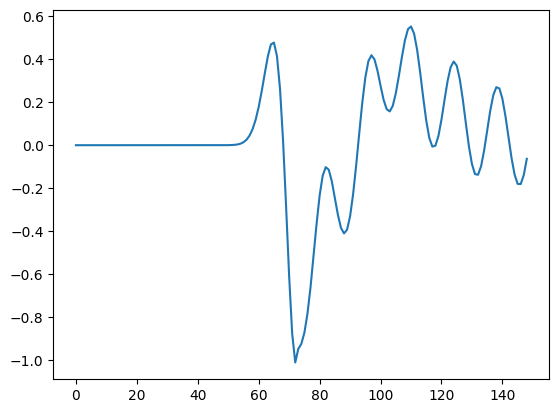

In [72]:
from matplotlib import pyplot as plt
plt.plot(point_detector.recorded_values)